## Astro 304 "Galaxies"

### Morphology and properties of galaxy light distribution

In [5]:
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)


We will use <a href="http://www.physics.upenn.edu/~ameert/SDSS_PhotDec/download/">UPenn catalogs</a> with their model photometry fits to the SDSS DR7 main galaxy sample (<a href="http://adsabs.harvard.edu/abs/2015MNRAS.446.3943M">Meert et al. 2015</a>). The catalog files are available in the data/ directory shared with you previously.

In [6]:
import numpy as np
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# to save space the routine to read the catalog is now in code/read_data
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];

# make some cuts to eliminate bad regimes or catastrophic failures
ilim = (vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']

# concentration of light, Sersic index, image axis ratio b/a
cr = phot_r['petroR90']/phot_r['petroR50']; nser = mdata['n_bulge']; ba = mdata['ba_tot']; 

print "selected", np.size(zm), " after all cuts..."

# inverse Vmax
vmaxi = 1.0/vmaxm[ilim] 
# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# Bayesian machine learning probabilities of morphological classes from Huertas-Company et al. 2011, AA 525, 157
# probaE is probability to be early type (either E or S0); 1-probaE is probability to be spiral
# probaEll = probability to be elliptical; probaS0 = p(S0); probaSab = p(Sa or Sb); probaScd = p(Sc, Sd, or Irr)
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 


670722 galaxies in Meert et al. sample initially
selected 240115  after all cuts...


selected 240115  after all cuts...
best fit Schechter parameters: phi_*=1.04e-02 [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=10.24, alpha=-0.13


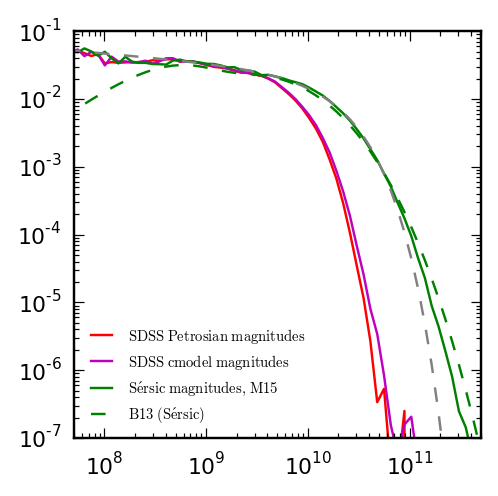

In [17]:
import numpy as np

def compute_lf_bootstrap (lum, vmi, lbins, nbootstraps = 20):
    """
    computes LF and bootstrap errors given a vector of luminosities
    lum, 1/Vmax values (vmi), and specified luminosity bins (lbins)
    """
    l_dist = np.zeros((nbootstraps, len(lbins) - 1))

    for i in range(nbootstraps):
        ind = np.random.randint(0, len(lum), len(lum))
        l_dist[i], ldbins = np.histogram(lum[ind], weights=vmi[ind], bins=lbins)

    return (l_dist.mean(0), l_dist.std(0, ddof=1))

grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']


# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# impose sample limits
size = phot_r['petroR50']
# surface brightess = -2.5log10(f/(pi*r^2))+ const
# term - 2.5*np.log10(0.5) below is to account that we are using the *half* light radius
extm = mnpdata['extinction']
mrm = phot_r['petroMag'] - extm
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])

ilim = (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']


print "selected", np.size(zm), " after all cuts..."

vmaxm = mnpdata['Vmax']

d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# compute k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
#from code.calc_kcor import calc_kcor 
#ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
#kcorr = calc_kcor('r', zk, 'g - r', grm)

# absolute magnitude in the r-band corrected for extinction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;
Mmodel = phot_r['ModelMag'] - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); Lpetrom = 0.4*(4.67-Mpetrom)
Lmodel = 0.4*(4.67-(Mmodel))
zsb = (1.+zm)*np.power(10.,0.1*(23.-sb50)) - 1.0
zsb[zsb>1] = 1.
d_Msb = cosmo.luminosityDistance(zsb)/cosmo.h/(1.+zsb)
d_Mmax[(d_Msb<d_Mmax)] = d_Msb[(d_Msb<d_Mmax)]

vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

solid_anglem = 4.*np.pi/3*0.195
#solid_anglem = 4681.*(np.pi/180)**2
vmaxim = vmaxim / (solid_anglem*ccm)
#vmaxim = 1.0/vmaxm/ccm

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 10; nbins = 80
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)

phi_Lpetro, ephi_Lpetro = compute_lf_bootstrap(Lpetrom, vmaxim, Lbins, nbootstrap)
phi_Lmodel, ephi_Lmodel = compute_lf_bootstrap(Lmodel, vmaxim, Lbins, nbootstrap)


phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = np.nan_to_num(ephi_Lbsmeert)

phi_Lpetro = phi_Lpetro  / dLbins / cosmo.h**3
ephi_Lpetro = ephi_Lpetro  / dLbins / cosmo.h**3
ephi_Lpetro = np.nan_to_num(ephi_Lpetro)

phi_Lmodel = phi_Lmodel  / dLbins / cosmo.h**3
ephi_Lmodel = ephi_Lmodel  / dLbins / cosmo.h**3
ephi_Lmodel = np.nan_to_num(ephi_Lmodel)

Lbinc = np.log10(10.**Lbinc*cosmo.h**2)

from scipy.optimize import curve_fit

def lf_schechter(L, phis, Lstar, alpha):
    mus = np.power(10,L)/np.power(10,Lstar)
    #print "phis, Lstar, alpha", phis, Lstar, alpha
    return np.log(10.)*phis*mus**(alpha)*np.exp(-mus)

p0 = [2.5e-3, 10.5, -0.3]
fitsel = (phi_Lbsmeert>1.e-7) & (Lbinc>8.) 
Lbfit = Lbinc[fitsel]; phi_fit = phi_Lbsmeert[fitsel]; ephi_fit = ephi_Lbsmeert[fitsel]

popt, pcov = curve_fit(lf_schechter, Lbfit, phi_fit, sigma=ephi_fit, p0 =p0, check_finite=True) 
print "best fit Schechter parameters: phi_*=%.2e [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=%.2f, alpha=%.2f"%(popt[0],popt[1],popt[2])

#
# plot LF
#
import matplotlib.pyplot as plt

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

fig = plt.figure(figsize=(3, 3))

#plt.xlabel(r'$L_r\ (h^{-2}\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 5e11); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
#plt.rc('font',size=11)

plt.plot(10.**Lbinc, phi_Lpetro, c='r', label=r'$\mathrm{SDSS\ Petrosian\ magnitudes}$')
plt.plot(10.**Lbinc, phi_Lmodel, c='m', label=r'$\mathrm{SDSS\ cmodel\ magnitudes}$')
plt.plot(10.**Lbinc, phi_Lbsmeert, c='g', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ M15}$')

#plt.errorbar(10.**Lbinc, phi_Lbsmeert, yerr=ephi_Lbsmeert, c='g')
# plot Schechter fit
Lsexp = int(popt[1]); Lsnum = popt[1] - Lsexp
plt.plot(10.**Lbinc, lf_schechter(Lbinc, popt[0], popt[1], popt[2]), '--', c='gray')#, 
#         label=r'$\mathrm{Schechter\ fit:}\\\ \alpha=%.2f,\,L_*=%.1f\times 10^{%d}$'%((popt[2]-1),10.**Lsnum,Lsexp))

#
# plot the best double Schechter function from Bernardi et al. (2013)
#
import math

ms = 10.**Lbinc*(0.73/0.7)**2/cosmo.h**2

# Sersic photometry LF parameters
mstarb = 0.0187e9; phisb = 1.343e-2; alphab = 1.678; betab = 0.3
phisg = 0.843e-2; mstarg = 0.8722e9; gammag = 1.058
gammanorm = math.gamma(alphab/betab)

musb = ms/mstarb; musg = ms/mstarg
phiLB13_ser = (0.7/0.73)**3*np.log(10.)*(phisb*np.exp(-musb**betab)*musb**(alphab)*betab/gammanorm +
         phisg*musg**(gammag)*np.exp(-musg))


plt.plot(10.**Lbinc, phiLB13_ser/cosmo.h**3, '--', c='g', label=r'$\mathrm{B13\ (S\acute{e}rsic)}$')

plt.legend(loc='lower left', fontsize=6, frameon=False)

plt.show()

### Using Vmax method to correct Malmquist bias in the histograms of galaxy properties

First, let's plot diagrams of some properties for the entire galaxy sample

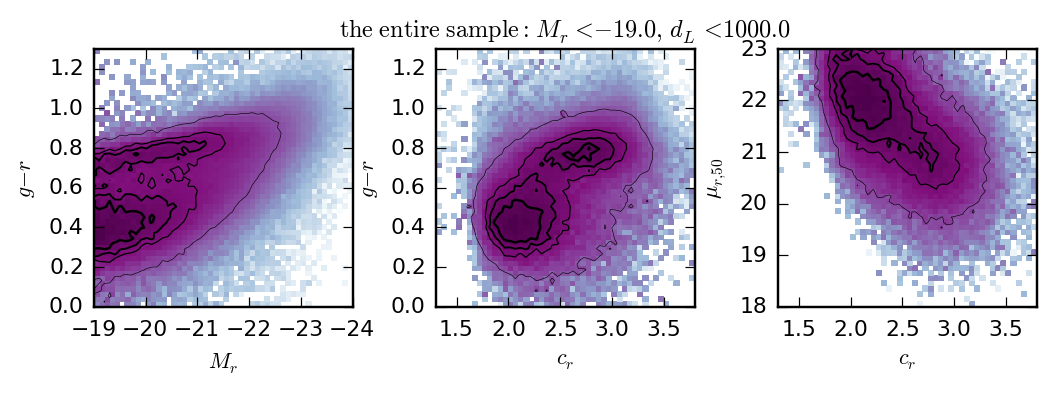

In [18]:
from code.plot_utils import plot_2d_dist

# select a sample of nearby SDSS galaxies down to a given luminosity to get reasonably detailed images
Mlim = -19.0; Dmax = 1000.
ipos = ((pEll<0) | (pS0<0) | (pSab<0) | (pScd<0))
iloc = (Mmeert < Mlim) & (20. < d_Lm) & (d_Lm < Dmax) & (pEll>=0) & (pS0>=0) & (pSab>=0) & (pScd>=0) 
grmloc = grm[iloc]; Mmloc  = Mmeert[iloc]
dLl = d_Lm[iloc]; vmaxiloc = vmaxi[iloc]
crloc = cr[iloc]; murloc= sb50[iloc]

Mrlim = [-24.,Mlim]; grlim = [0.,1.3];
crlim = [1.3,3.8]; sblim = [18., 23.]

clevs = np.linspace(0.2,0.95,4)

fig, ax = plt.subplots(1,3,figsize=(6., 2.0))
fig.tight_layout()

plot_2d_dist(Mmloc, grmloc, Mrlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$g-r$', fig_setup=ax[0])

ax[1].set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)
plot_2d_dist(crloc, grmloc, crlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$g-r$', fig_setup=ax[1])

plot_2d_dist(crloc, murloc, crlim, sblim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$\mu_{r,50}$', fig_setup=ax[2])

#plt.savefig('fig/colcrmur.pdf',bbox_inches='tight')
plt.show()


Now explore these and other properties for galaxies as a function of a given morphological class. Insert the cell below and repeat above for different morphological classes.

### Automated morphological classification using supervised learning

We will want to consider various galaxy properties as a function of morphology even in the cases when detailed morphology is not available or not reliable. For this, we can use supervised machine learning algorithms to train classification on some robust properties that can be measured robustly form galaxy photometry. There are two steps: 1) train the classified using a carefully selected training sample and set of parameters, 2) use the trained classified to classify the entire sample.

Below I compare results of three such classification algorithms: support vector machines (SVM), Randomized Forest Trees, and Extremely Randomized Trees, which are usually considered to be the most robust. You can read about these algorithms in Ch. 9 of <a href="http://www.astroml.org/index.html">"Statistics, Data Mining, and Machine Learning in Astronomy"</a> by Ivezic et al. or in the scikit-learn docs <a href="http://scikit-learn.org/stable/modules/svm.html">here</a> and <a href="http://scikit-learn.org/stable/modules/ensemble.html#forest"></a>. It is also key to choose the properties used to train the classified and which then can be used to assign morphological classes. Below I've chosen three properties, which seem to work reasonably well. You can try to play with adding or substituting other properties (e.g., absolute magnitude, surface brightness). You can also try to understand parameters of these algorithms and how they affect results of classification.   

using 5000 galaxies as a training sample
for SVM classification method:
completeness for the entire Ell sample = 0.878
completeness for the clean  Ell sample = 0.951
completeness for the entire S0  sample = 0.726
completeness for the clean  S0  sample = 0.924
completeness for the entire Sab sample = 0.655
completeness for the clean  Sab sample = 0.845
completeness for the entire Scd sample = 0.762
completeness for the clean  Scd sample = 0.930
for Random forest classification method:
completeness for the entire Ell sample = 0.893
completeness for the clean  Ell sample = 0.957
completeness for the entire S0  sample = 0.615
completeness for the clean  S0  sample = 0.891
completeness for the entire Sab sample = 0.699
completeness for the clean  Sab sample = 0.888
completeness for the entire Scd sample = 0.784
completeness for the clean  Scd sample = 0.945
for Extremely random trees classification method:
completeness for the entire Ell sample = 0.910
completeness for the clean  Ell sample

/home/tangq/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


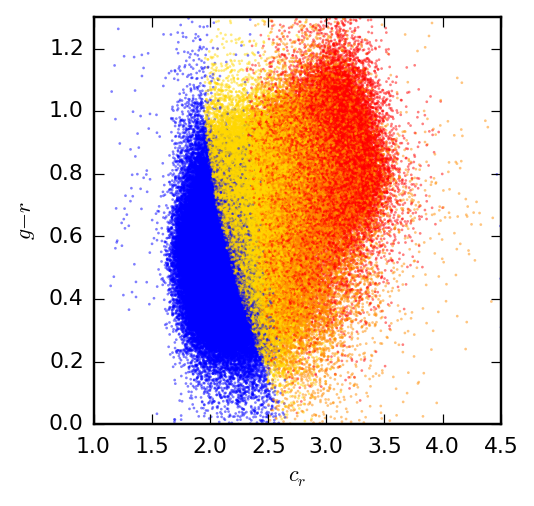

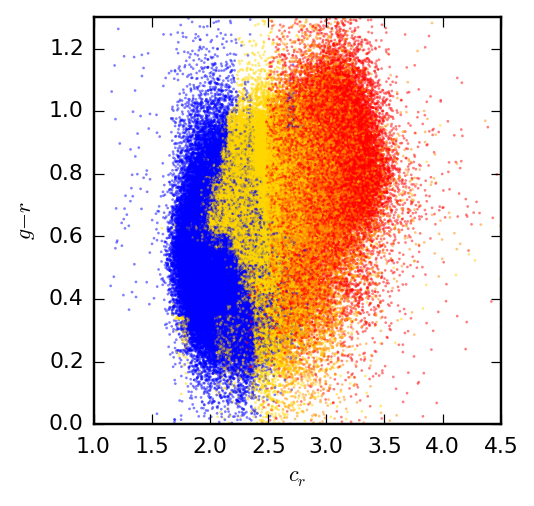

In [13]:
# define indices of galaxies that have the highest probability in each class
iEll = ( (pEll>pS0) & (pEll>pSab) & (pEll>pScd))
iS0  = ( (pS0>pEll) & (pS0>pSab) & (pS0>pScd))
iSab = ((pSab>pEll) & (pSab>pS0) & (pSab>pScd))
iScd = ((pScd>pEll) & (pScd>pS0) & (pScd>pSab))

mclass = np.zeros(np.shape(pE)[0], dtype = np.int); mclass_weights = np.zeros(np.shape(pE)[0], dtype = np.float)
mclass[iEll] = 1; mclass[iS0] = 2; mclass[iSab] = 3; mclass[iScd] = 4
mclass_weights[iEll] = pEll[iEll]; mclass_weights[iS0] = pS0[iS0]; 
mclass_weights[iSab] = pSab[iSab]; mclass_weights[iScd] = pScd[iScd]

# select relatively nearby galaxies which are not affected much by seeing and with clean (high prob.) class
Dmax = 200.; Mlim = -17.0
pclean = 0.7 # somewhat arbitrary definition of cleanliness...
itrain = (mclass_weights>pclean) & (phot_r['petroR50']>3.) & (Mmeert < Mlim) & (d_Lm>20.) & (d_Lm < Dmax)

# define parameters for the training sample, cr = R90/R50, ba = image axis ratio b/a
crtrain = cr[itrain]; Mtrain = Mmeert[itrain]; batrain = ba[itrain]; grtrain= grm[itrain]
mctrain = mclass[itrain]
# select a random subsample for classification
nsample = np.minimum(5000,np.size(mctrain)-1)

print "using %d galaxies as a training sample"%nsample

# get random indices
iran = np.random.randint(0.,np.size(mctrain)-1, nsample)
# classify in the space of c/a, cr, and g-r
X1 = np.column_stack((batrain[iran],crtrain[iran],grtrain[iran]))
ccol1 = np.column_stack((ba,cr,grm))

# classify using support vector classification
from sklearn.svm import SVC
classmodel1 = SVC(kernel='rbf', gamma=1.0, class_weight='auto', probability=False)

from sklearn.ensemble import RandomForestClassifier
# classify using random forest method
classmodel2 = RandomForestClassifier(n_estimators=20, max_features=2,max_depth=None, min_samples_split=1, random_state=0)

# classify using extremely randomized trees method
from sklearn.ensemble import ExtraTreesClassifier
classmodel3 = ExtraTreesClassifier(n_estimators=20, max_features=2,max_depth=None, min_samples_split=1, random_state=0)

clmethods = ['SVM','Random forest','Extremely random trees']

# not fit the models to the training sample with clean classes
classmodel1.fit(X1, mctrain[iran])
classmodel2.fit(X1, mctrain[iran])
classmodel3.fit(X1, mctrain[iran])

# assign model predicted class for each galaxy in the sample now

y_1 = classmodel1.predict(ccol1)
y_2 = classmodel2.predict(ccol1)
y_3 = classmodel3.predict(ccol1)

# check contamination of the classifications for the entire sample using original probabilities as reference
from __future__ import division

for i, y_ in enumerate([y_1, y_2, y_3]):
    print "for %s classification method:"%clmethods[i]
    print "completeness for the entire Ell sample = %.3f"%(np.size(y_[iEll & (y_==1)])/np.size(y_[iEll]))
    print "completeness for the clean  Ell sample = %.3f"%(np.size(y_[(pEll>pclean) & (y_==1)])/np.size(y_[pEll>pclean]))
    print "completeness for the entire S0  sample = %.3f"%(np.size(y_[iS0 & (y_==2)])/np.size(y_[iS0]))
    print "completeness for the clean  S0  sample = %.3f"%(np.size(y_[(pS0>pclean) & (y_==2)])/np.size(y_[pS0>pclean]))
    print "completeness for the entire Sab sample = %.3f"%(np.size(y_[iSab & (y_==3)])/np.size(y_[iSab]))
    print "completeness for the clean  Sab sample = %.3f"%(np.size(y_[(pSab>pclean) & (y_==3)])/np.size(y_[pSab>pclean]))
    print "completeness for the entire Scd sample = %.3f"%(np.size(y_[iScd & (y_==4)])/np.size(y_[iScd]))
    print "completeness for the clean  Scd sample = %.3f"%(np.size(y_[(pScd>pclean) & (y_==4)])/np.size(y_[pScd>pclean]))
#
# plot
#
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
plt.ylabel(r'$g-r$'); plt.xlabel(r'$c_r$')
grlim = [0.0, 1.3]; crlim = [1.,4.5]
plt.ylim(grlim); plt.xlim(crlim)

colclass = ['black','r','darkorange','gold','b']

ptcol = [0]*np.int(np.shape(cr)[0])
for i, cl in enumerate(y_1):
    if cl == 1: ptcol[i] = colclass[1]
    elif cl==2: ptcol[i] = colclass[2]
    elif cl==3: ptcol[i] = colclass[3]
    elif cl==4: ptcol[i] = colclass[4]

plt.scatter(cr, grm, marker='.', s=5.0, edgecolor='none', alpha=0.5, c=ptcol, cmap=plt.cm.Paired)

plt.show()


fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
plt.ylabel(r'$g-r$'); plt.xlabel(r'$c_r$')
#grlim = [0.0, 1.3]; crlim = [0.,1000.]
plt.ylim(grlim); plt.xlim(crlim)

colclass = ['black','r','darkorange','gold','b']

ptcol = [0]*np.int(np.shape(cr)[0])
for i, cl in enumerate(y_2):
    if cl == 1: ptcol[i] = colclass[1]
    elif cl==2: ptcol[i] = colclass[2]
    elif cl==3: ptcol[i] = colclass[3]
    elif cl==4: ptcol[i] = colclass[4]

plt.scatter(cr, grm, marker='.', s=5.0, edgecolor='none', alpha=0.5, c=ptcol, cmap=plt.cm.Paired)


plt.show()

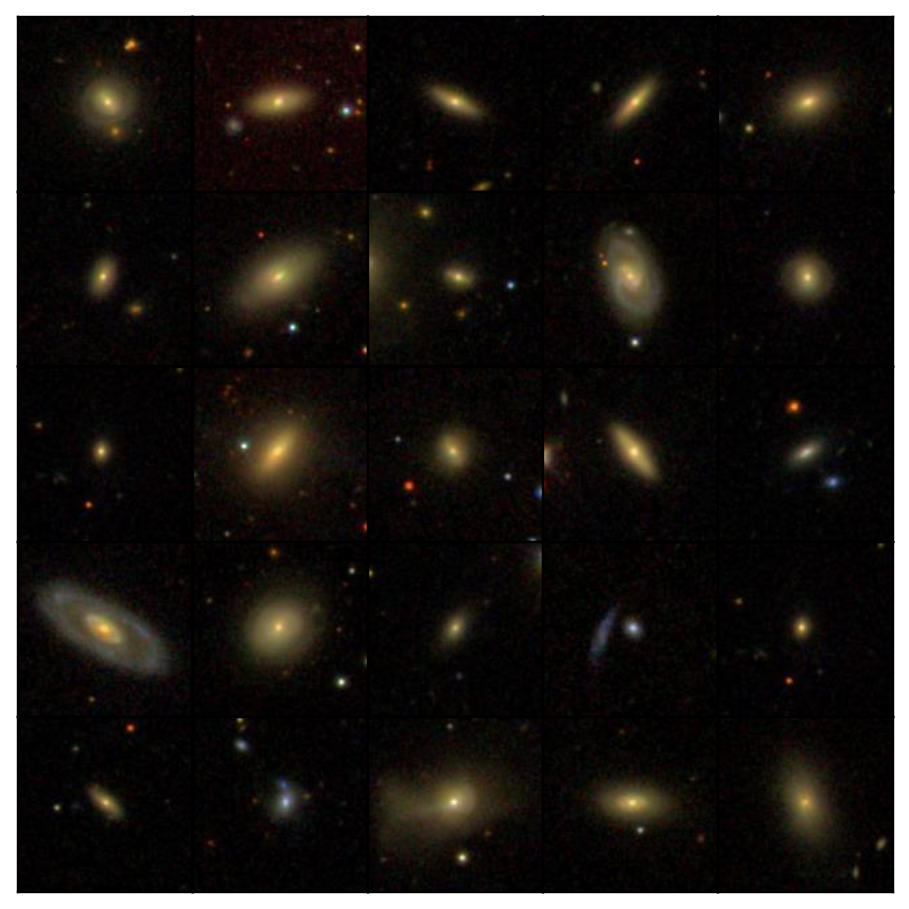

In [14]:
from code.plot_utils import sdss_img_collage

nrow = 5; ncol = 5
npix = 130

Dmax = 200.; Mlim = -19.0

rdata = sdata[(y_1==2) & (Mmeert < Mlim) & (d_Lm>20.) & (d_Lm < Dmax)]
iran = np.random.randint(0.,np.size(rdata)-1,nrow*ncol)
dshow = rdata[iran]
objs = dshow['objid']; ras = dshow['ra']; decs = dshow['dec']

sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.5)